<a href="https://colab.research.google.com/github/lisahqwang/ML-DL-CV/blob/main/Neural_Network_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unbiased estimation: Training phi and psi as two neural networks, enhancements and visualization
## Section author: Lisa (hw3082)

The Neural Network Approach builds upon the previous section, but with an increase of the dimensionality from 2 to 16.

- $\Phi(W)$ and $\Psi(x)$ will be trained to approximate $\operatorname{GELU}(W x)$.
- We'll build both as neural networks:
- $\Psi(x)$ will map the input vector $x \in \mathbb{R}^d$ to a feature space $\mathbb{R}^m$.
- $\Phi(W)$ will map the weight matrix $W \in \mathbb{R}^{d \times d}$ to a projection in $\mathbb{R}^{d \times m}$.



We would like to use backpropagation to train the model to reduce loss, which is the Mean Squared Error (MSE) between the output of the linearized model and the true GELU function:

$\mathbb{E}\left[\|\Phi(W) \Psi(x)-\operatorname{GELU}(W x)\|^2\right]$

Parameters are updated accordingly


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set dimensions
d = 16  # input/output size
m = 64  # intermediate size

# GELU activation
gelu = nn.GELU()

# Psi: Maps x ∈ ℝ^d → ℝ^m
class Psi(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 2*m),
            nn.ReLU(),
            nn.Linear(2*m, m)
        )

    def forward(self, x):
        return self.net(x)  # Shape: (batch, m)

# Phi: Maps W ∈ ℝ^{d×d} → ℝ^{d×m}
class Phi(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d * d, d*m),
            nn.ReLU(),
            nn.Linear(d*m , d * m)
        )
        self.d = d
        self.m = m

    def forward(self, W):
        W_flat = W.view(W.size(0), -1)  # Shape: (batch, d*d)
        out = self.net(W_flat)          # Shape: (batch, d*m)
        return out.view(-1, self.d, self.m)  # Shape: (batch, d, m)

# Full model
class LinearizedGELU(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.psi = Psi(d, m)
        self.phi = Phi(d, m)

    def forward(self, x, W):
        psi_x = self.psi(x)             # (batch, m)
        phi_W = self.phi(W)             # (batch, d, m)
        y_hat = torch.bmm(phi_W, psi_x.unsqueeze(2)).squeeze(2)  # (batch, d)
        return y_hat

# Training loop (simple)
def train_model():
    model = LinearizedGELU(d, m)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for step in range(2000):
        # Sample random input
        x = torch.randn(32, d)                 # batch of x
        W = torch.randn(32, d, d)              # batch of W
        y = gelu(torch.bmm(W, x.unsqueeze(2)).squeeze(2))  # GELU(Wx)

        # Forward pass
        y_hat = model(x, W)

        # Loss and optimize
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")

train_model()


Step 0, Loss: 10.2267
Step 100, Loss: 5.4215
Step 200, Loss: 5.4084
Step 300, Loss: 5.0272
Step 400, Loss: 4.7877
Step 500, Loss: 4.9924
Step 600, Loss: 4.6746
Step 700, Loss: 4.2438
Step 800, Loss: 3.6211
Step 900, Loss: 3.9059
Step 1000, Loss: 3.5682
Step 1100, Loss: 3.7633
Step 1200, Loss: 3.5355
Step 1300, Loss: 3.8380
Step 1400, Loss: 3.6384
Step 1500, Loss: 3.6839
Step 1600, Loss: 3.2159
Step 1700, Loss: 2.6453
Step 1800, Loss: 3.0430
Step 1900, Loss: 2.7986


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# GELU function (standard)
def gelu(x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * x**3))) # Changed this line to convert the result of 2.0 / torch.pi to a PyTorch tensor before passing it to torch.sqrt()

# Ψ(x): Neural network mapping x ∈ ℝ^d → ℝ^m
class Psi(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 2*m),
            nn.ReLU(),
            nn.Linear(2 * m, m)
        )

    def forward(self, x):
        return self.net(x)

# Φ(W): Neural network mapping W ∈ ℝ^{d×d} → ℝ^{d×m}
class Phi(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d * d, d * m),
            nn.ReLU(),
            nn.Linear(d * m, d * m)
        )
        self.d = d
        self.m = m

    def forward(self, W):
        W_flat = W.view(W.size(0), -1)  # Flatten W to shape (batch, d*d)
        out = self.net(W_flat)          # Shape: (batch, d*m)
        return out.view(-1, self.d, self.m)  # Reshape to (batch, d, m)

# Linearized GELU model using Φ(W) and Ψ(x)
class LinearizedGELU(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.psi = Psi(d, m)
        self.phi = Phi(d, m)

    def forward(self, x, W):
        psi_x = self.psi(x)             # Shape: (batch, m)
        phi_W = self.phi(W)             # Shape: (batch, d, m)
        y_hat = torch.bmm(phi_W, psi_x.unsqueeze(2)).squeeze(2)  # Shape: (batch, d)
        return y_hat

# Training loop
def train_linearized(d=16, m=64, steps=2000):
    model = LinearizedGELU(d, m)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for step in range(steps):
        # Sample random batch
        x = torch.randn(64, d)               # input vectors
        W = torch.randn(64, d, d)            # weight matrices

        # True target: GELU(Wx)
        Wx = torch.bmm(W, x.unsqueeze(2)).squeeze(2)  # Shape: (batch, d)
        y_true = gelu(Wx)

        # Predicted y'
        y_pred = model(x, W)

        # Loss
        loss = loss_fn(y_pred, y_true)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.6f}")

    return model

# Run training
model = train_linearized()

Step 0, Loss: 7.615752
Step 100, Loss: 5.270417
Step 200, Loss: 4.861650
Step 300, Loss: 4.227475
Step 400, Loss: 3.202856
Step 500, Loss: 3.685356
Step 600, Loss: 3.014122
Step 700, Loss: 3.318587
Step 800, Loss: 2.837200
Step 900, Loss: 2.836414
Step 1000, Loss: 2.846874
Step 1100, Loss: 2.769109
Step 1200, Loss: 2.686871
Step 1300, Loss: 2.471438
Step 1400, Loss: 2.600103
Step 1500, Loss: 2.843266
Step 1600, Loss: 2.631226
Step 1700, Loss: 3.017424
Step 1800, Loss: 2.229889
Step 1900, Loss: 2.631196


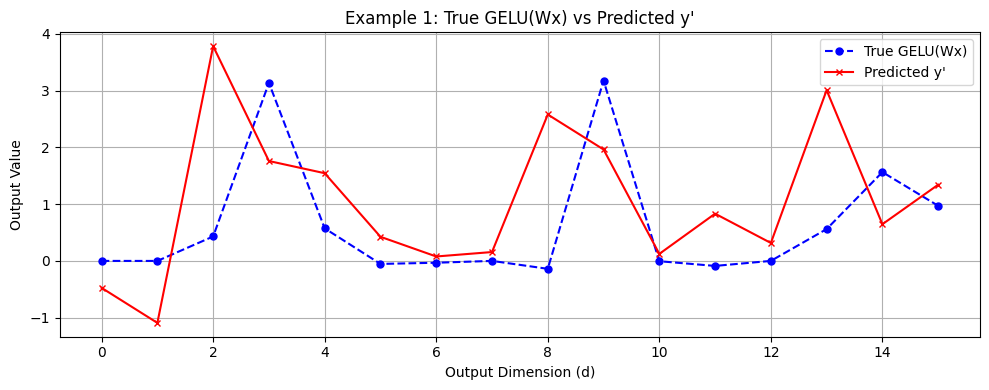

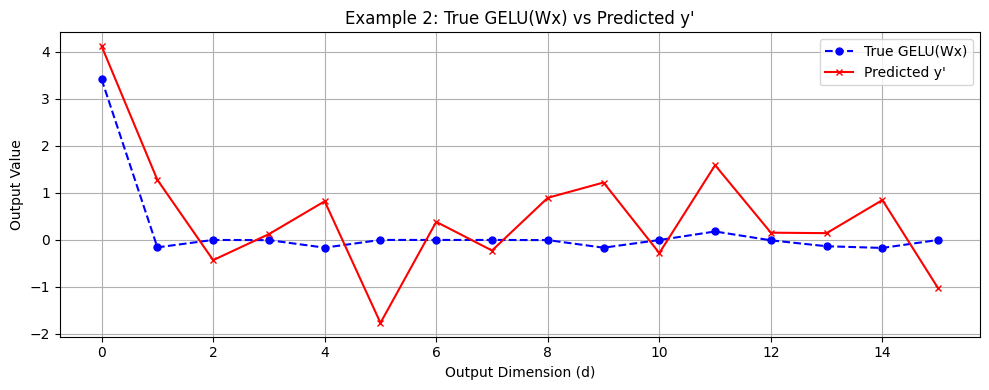

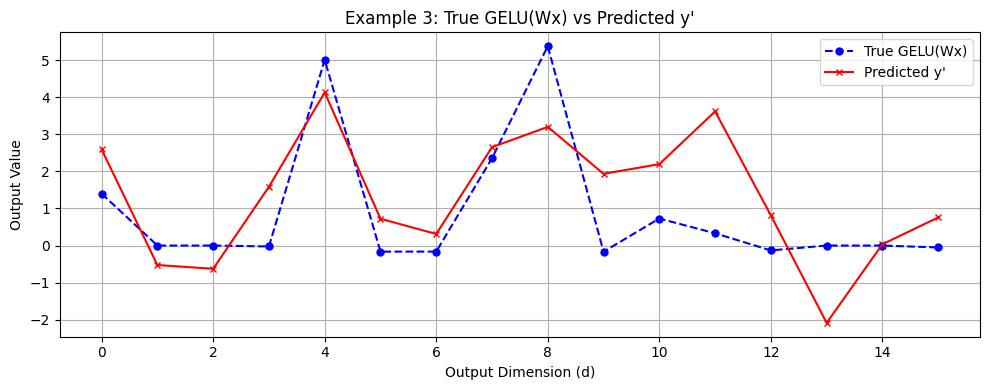

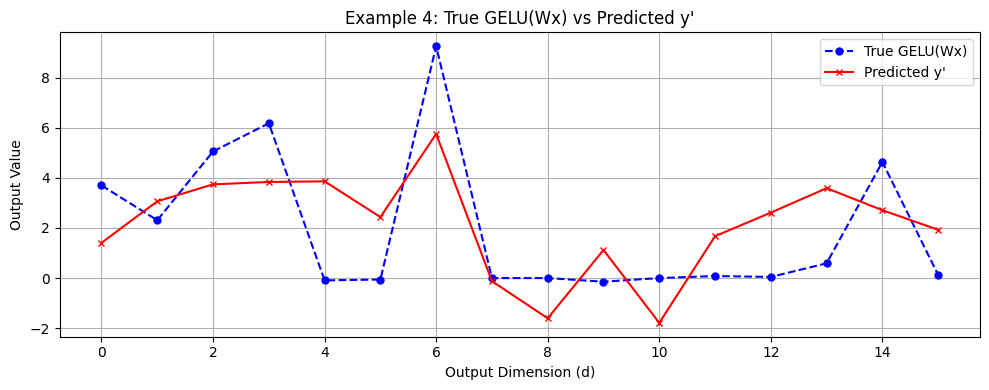

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_approximation(model, num_examples=4):
    model.eval()

    d = 16  # input dimension
    m = 64  # feature space dimension (from model)

    # Generate random test data
    x = torch.randn(num_examples, d)  # input vectors
    W = torch.randn(num_examples, d, d)  # weight matrices

    with torch.no_grad():
        # True target: GELU(Wx)
        Wx = torch.bmm(W, x.unsqueeze(2)).squeeze(2)  # shape: (num_examples, d)
        y_true = gelu(Wx)  # GELU(Wx) output

        # Predicted y'
        y_pred = model(x, W)  # shape: (num_examples, d)

    # Plot the comparison between true and predicted values
    for i in range(num_examples):
        plt.figure(figsize=(10, 4))

        # Plot true GELU(Wx) vs predicted y'
        plt.plot(y_true[i].numpy(), label="True GELU(Wx)", marker='o', markersize=5, linestyle='--', color='b')
        plt.plot(y_pred[i].numpy(), label="Predicted y'", marker='x', markersize=5, linestyle='-', color='r')

        # Title and labels
        plt.title(f"Example {i+1}: True GELU(Wx) vs Predicted y'")
        plt.xlabel("Output Dimension (d)")
        plt.ylabel("Output Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plt.show()

# Visualize after training
visualize_approximation(model)


In [6]:
import matplotlib.pyplot as plt

# Modified training loop to track loss at each step
def train_linearized_with_loss_tracking(d=16, m=64, steps=2000):
    model = LinearizedGELU(d, m)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    # List to store loss values at each step
    loss_history = []

    for step in range(steps):
        # Sample random batch
        x = torch.randn(64, d)               # input vectors
        W = torch.randn(64, d, d)            # weight matrices

        # True target: GELU(Wx)
        Wx = torch.bmm(W, x.unsqueeze(2)).squeeze(2)  # Shape: (batch, d)
        y_true = gelu(Wx)

        # Predicted y'
        y_pred = model(x, W)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking loss
        loss_history.append(loss.item())

        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.6f}")

    return model, loss_history

# Train the model and track loss
model, loss_history = train_linearized_with_loss_tracking()

# Plot loss history
plt.plot(loss_history, label="Training Loss")
plt.title("Training Loss Over Steps")
plt.xlabel("Training Steps")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("The final training loss is around 2.013")

Step 0, Loss: 7.877669


KeyboardInterrupt: 